In [1]:
"""Use GMRES and augmented least squares to find optimal Tikhonov regularisation"""

'Use GMRES and augmented least squares to find optimal regularisation'

In [2]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter

from deblurring.blurring import blur_and_noise
from deblurring.solvers import GMRESSolver, LSQRSolver
from common.operators import derivative_operator, identity_operator
from evaluation.tuning import StandardTuner

[INFO] 2024-11-24 13:09:56 | Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16. | numexpr.utils-_init_num_threads:148
[INFO] 2024-11-24 13:09:56 | NumExpr defaulting to 16 threads. | numexpr.utils-_init_num_threads:161


Estimated noise variance 0.00040318719684889943 vs. actual 0.0004


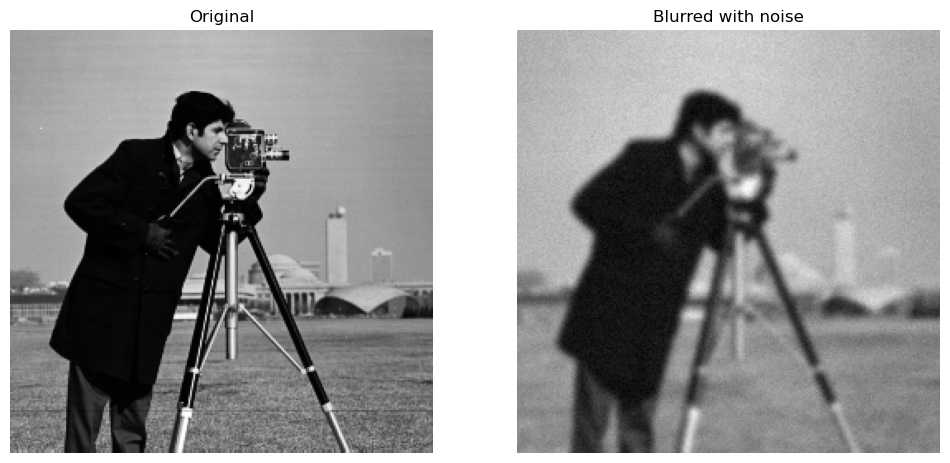

In [3]:
"""Read image and blur with added noise"""

f = plt.imread("../data/Cameraman256.png").astype("float32")
f = (f - f.min()) / (f.max() - f.min())

theta = 0.02
sigma = 2.0
kernel = partial(gaussian_filter, sigma=sigma)
g = blur_and_noise(f, kernel, theta)
noise_variance = np.var(blur_and_noise(np.zeros_like(g), kernel, theta))
print(f"Estimated noise variance {noise_variance} vs. actual {np.square(theta)}")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(f, cmap="gray")
plt.axis("off")
plt.title("Original")
plt.subplot(1, 2, 2)
plt.imshow(g, cmap="gray")
plt.axis("off")
plt.title("Blurred with noise")
plt.show()

In [4]:
"""Set up parameters, regularisation operators and tuners"""

alphas = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1]
identity = identity_operator(f)
derivative = derivative_operator(f)

gmres_tuner = StandardTuner(
    g=g,
    kernel=kernel,
    solver=GMRESSolver,
    noise_variance=noise_variance,
    f=f,
)

lsqr_tuner = StandardTuner(
    g=g,
    kernel=kernel,
    solver=LSQRSolver,
    noise_variance=noise_variance,
    f=f,
)

[INFO] 2024-11-24 13:10:16 | Alpha 1e-08: DP -0.00011166534707073071 | evaluation.tuning-parameter_sweep:264
[INFO] 2024-11-24 13:10:36 | Alpha 1e-07: DP -0.00011139560079791058 | evaluation.tuning-parameter_sweep:264
[INFO] 2024-11-24 13:10:52 | Alpha 1e-06: DP -0.00010919413254375761 | evaluation.tuning-parameter_sweep:264
[INFO] 2024-11-24 13:10:59 | Alpha 1e-05: DP -0.00010071737983339944 | evaluation.tuning-parameter_sweep:264
[INFO] 2024-11-24 13:11:01 | Alpha 0.0001: DP -8.597059004041073e-05 | evaluation.tuning-parameter_sweep:264
[INFO] 2024-11-24 13:11:01 | Alpha 0.001: DP -6.774806742469079e-05 | evaluation.tuning-parameter_sweep:264
[INFO] 2024-11-24 13:11:02 | Alpha 0.01: DP -1.756055616419772e-05 | evaluation.tuning-parameter_sweep:264
[INFO] 2024-11-24 13:11:02 | Alpha 0.1: DP 0.0022723904141950003 | evaluation.tuning-parameter_sweep:264
[INFO] 2024-11-24 13:11:02 | Alpha 1.0: DP 0.06643167907380867 | evaluation.tuning-parameter_sweep:264
[INFO] 2024-11-24 13:11:02 | Alp

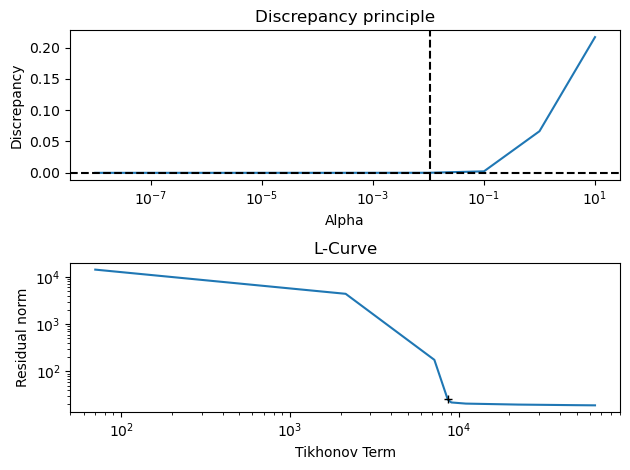

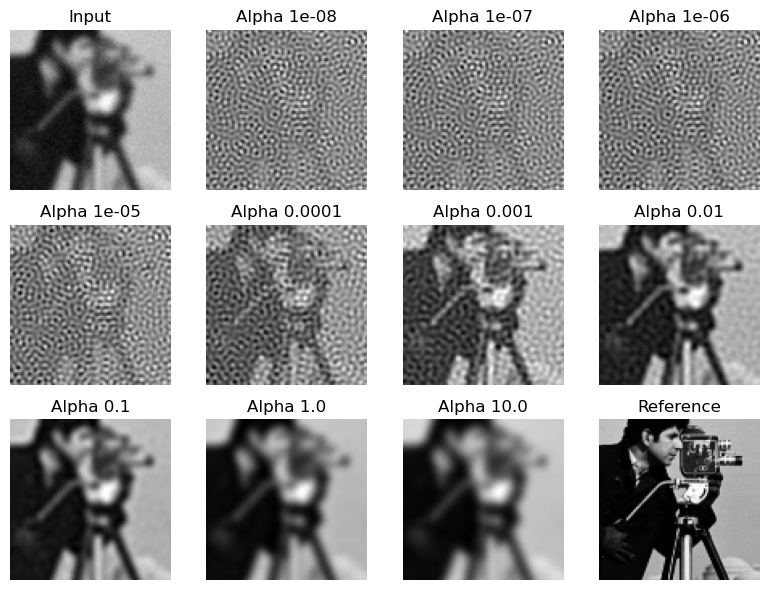

Optimal alpha: 0.0106901676390608
DP: -1.276658200060314e-05, MSE: 0.004454171010919795


In [5]:
"""Find optimal alpha using GMRES and TK0"""

gmres_tuner.parameter_sweep(
    alphas=alphas,
    L=identity,
    noise_variance=noise_variance,
    save_imgs=True
)
gmres_tuner.display_metrics()
gmres_tuner.display_sample()
print(f"Optimal alpha: {gmres_tuner.optimal_alpha}")
print(f"DP: {gmres_tuner.optimal_metrics['discrepancy']}, MSE: {gmres_tuner.optimal_metrics['MSE']}")
gmres_tk0_f_hat = gmres_tuner._optimal_f_hat

[INFO] 2024-11-24 13:11:03 | Alpha 1e-08: DP -8.821386870028458e-05 | evaluation.tuning-parameter_sweep:264
[INFO] 2024-11-24 13:11:03 | Alpha 1e-07: DP -8.821386024096631e-05 | evaluation.tuning-parameter_sweep:264
[INFO] 2024-11-24 13:11:04 | Alpha 1e-06: DP -8.821302375409414e-05 | evaluation.tuning-parameter_sweep:264
[INFO] 2024-11-24 13:11:04 | Alpha 1e-05: DP -8.81380052518065e-05 | evaluation.tuning-parameter_sweep:264
[INFO] 2024-11-24 13:11:04 | Alpha 0.0001: DP -8.492250701318293e-05 | evaluation.tuning-parameter_sweep:264
[INFO] 2024-11-24 13:11:05 | Alpha 0.001: DP -6.818283802220428e-05 | evaluation.tuning-parameter_sweep:264
[INFO] 2024-11-24 13:11:05 | Alpha 0.01: DP -1.764058256031588e-05 | evaluation.tuning-parameter_sweep:264
[INFO] 2024-11-24 13:11:05 | Alpha 0.1: DP 0.002272388106178723 | evaluation.tuning-parameter_sweep:264
[INFO] 2024-11-24 13:11:05 | Alpha 1.0: DP 0.06643167905313968 | evaluation.tuning-parameter_sweep:264
[INFO] 2024-11-24 13:11:05 | Alpha 10.

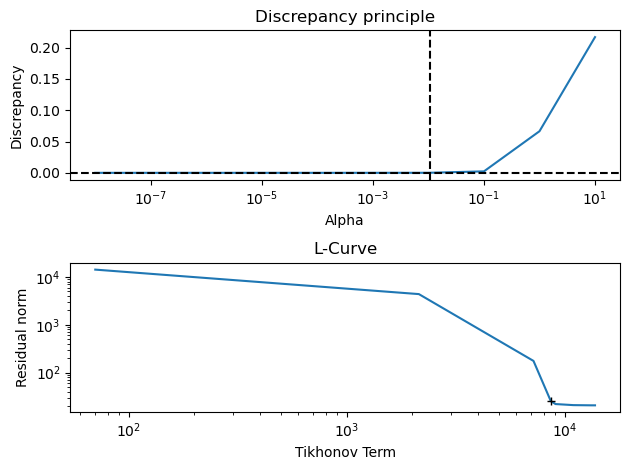

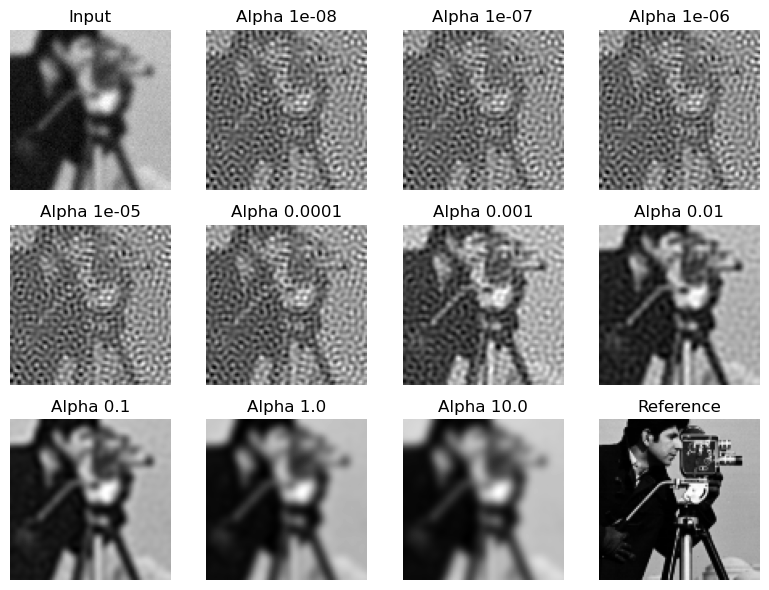

Optimal alpha: 0.010693289319140644
DP: -1.2837424028307718e-05, MSE: 0.004457156354690824


In [6]:
"""Find optimal alpha using LSQR and TK0"""

lsqr_tuner.parameter_sweep(
    alphas=alphas,
    L=identity,
    noise_variance=noise_variance,
    save_imgs=True
)
lsqr_tuner.display_metrics()
lsqr_tuner.display_sample()
print(f"Optimal alpha: {lsqr_tuner.optimal_alpha}")
print(f"DP: {lsqr_tuner.optimal_metrics['discrepancy']}, MSE: {lsqr_tuner.optimal_metrics['MSE']}")
lsqr_tk0_f_hat = lsqr_tuner._optimal_f_hat

[INFO] 2024-11-24 13:11:27 | Alpha 1e-08: DP -0.00011161957122593762 | evaluation.tuning-parameter_sweep:264
[INFO] 2024-11-24 13:11:47 | Alpha 1e-07: DP -0.00011090834912437145 | evaluation.tuning-parameter_sweep:264
[INFO] 2024-11-24 13:12:00 | Alpha 1e-06: DP -0.00010665678909150807 | evaluation.tuning-parameter_sweep:264
[INFO] 2024-11-24 13:12:05 | Alpha 1e-05: DP -9.581719219040557e-05 | evaluation.tuning-parameter_sweep:264
[INFO] 2024-11-24 13:12:06 | Alpha 0.0001: DP -8.077223370491697e-05 | evaluation.tuning-parameter_sweep:264
[INFO] 2024-11-24 13:12:07 | Alpha 0.001: DP -6.394177064946208e-05 | evaluation.tuning-parameter_sweep:264
[INFO] 2024-11-24 13:12:07 | Alpha 0.01: DP -4.2645181197665985e-05 | evaluation.tuning-parameter_sweep:264
[INFO] 2024-11-24 13:12:07 | Alpha 0.1: DP 3.0746378306568316e-05 | evaluation.tuning-parameter_sweep:264
[INFO] 2024-11-24 13:12:07 | Alpha 1.0: DP 0.000665679880535509 | evaluation.tuning-parameter_sweep:264
[INFO] 2024-11-24 13:12:07 | A

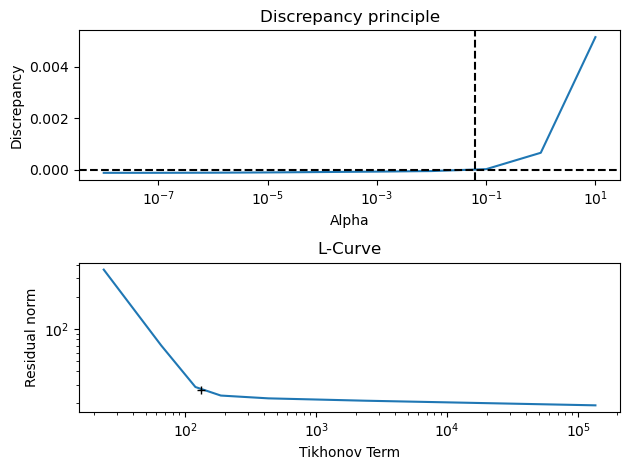

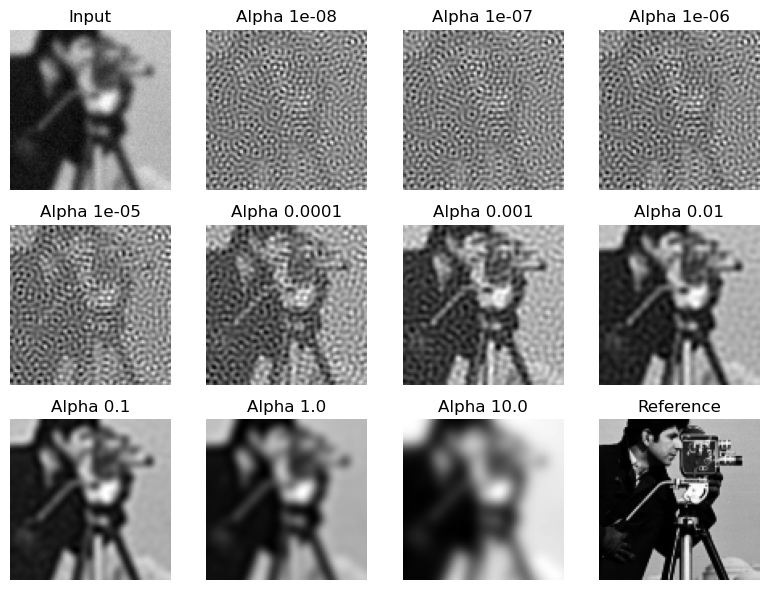

Optimal alpha: 0.062295745365221505
DP: 2.599456447275098e-06, MSE: 0.005003073586017439


In [7]:
"""Find optimal alpha using GMRES and TK1"""
gmres_tuner.parameter_sweep(
    alphas=alphas,
    L=derivative,
    noise_variance=noise_variance,
    save_imgs=True,
)
gmres_tuner.display_metrics()
gmres_tuner.display_sample()
print(f"Optimal alpha: {gmres_tuner.optimal_alpha}")
print(f"DP: {gmres_tuner.optimal_metrics['discrepancy']}, MSE: {gmres_tuner.optimal_metrics['MSE']}")
gmres_tk1_f_hat = gmres_tuner._optimal_f_hat

[INFO] 2024-11-24 13:12:09 | Alpha 1e-08: DP -8.82137721431262e-05 | evaluation.tuning-parameter_sweep:264
[INFO] 2024-11-24 13:12:09 | Alpha 1e-07: DP -8.821287153942998e-05 | evaluation.tuning-parameter_sweep:264
[INFO] 2024-11-24 13:12:09 | Alpha 1e-06: DP -8.820089792347172e-05 | evaluation.tuning-parameter_sweep:264
[INFO] 2024-11-24 13:12:10 | Alpha 1e-05: DP -8.785303050639444e-05 | evaluation.tuning-parameter_sweep:264
[INFO] 2024-11-24 13:12:10 | Alpha 0.0001: DP -8.119280687232574e-05 | evaluation.tuning-parameter_sweep:264
[INFO] 2024-11-24 13:12:10 | Alpha 0.001: DP -6.426164442733357e-05 | evaluation.tuning-parameter_sweep:264
[INFO] 2024-11-24 13:12:11 | Alpha 0.01: DP -4.2721982547732316e-05 | evaluation.tuning-parameter_sweep:264
[INFO] 2024-11-24 13:12:11 | Alpha 0.1: DP 3.07377364234053e-05 | evaluation.tuning-parameter_sweep:264
[INFO] 2024-11-24 13:12:11 | Alpha 1.0: DP 0.000665661175445308 | evaluation.tuning-parameter_sweep:264
[INFO] 2024-11-24 13:12:11 | Alpha 1

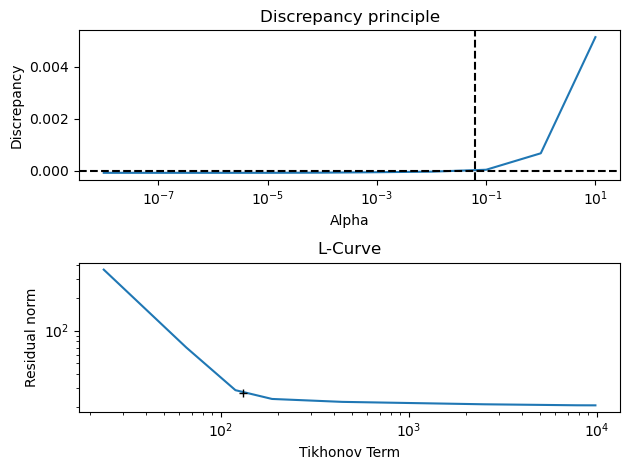

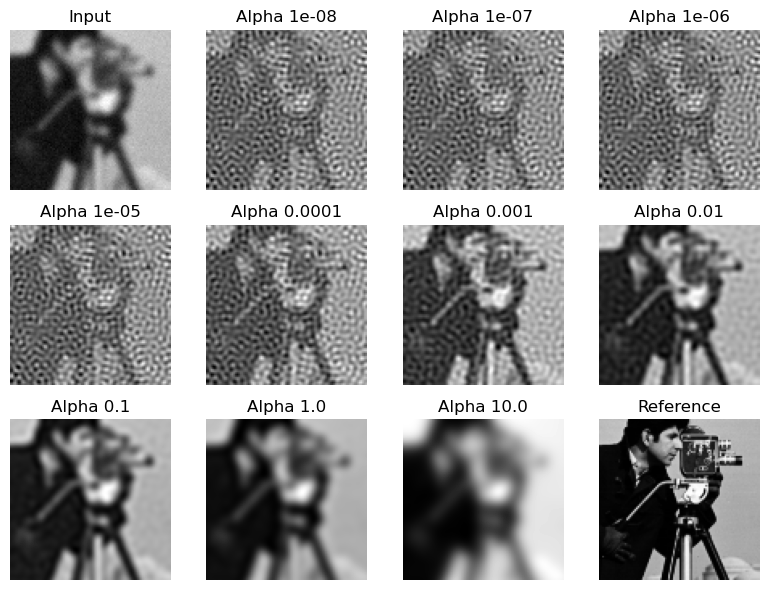

Optimal alpha: 0.06234131688969031
DP: 2.6226251614847843e-06, MSE: 0.005002911555822145


In [8]:
"""Find optimal alpha using LSQR and TK1"""
lsqr_tuner.parameter_sweep(
    alphas=alphas,
    L=derivative,
    noise_variance=noise_variance,
    save_imgs=True,
)
lsqr_tuner.display_metrics()
lsqr_tuner.display_sample()
print(f"Optimal alpha: {lsqr_tuner.optimal_alpha}")
print(f"DP: {lsqr_tuner.optimal_metrics['discrepancy']}, MSE: {lsqr_tuner.optimal_metrics['MSE']}")
lsqr_tk1_f_hat = lsqr_tuner._optimal_f_hat

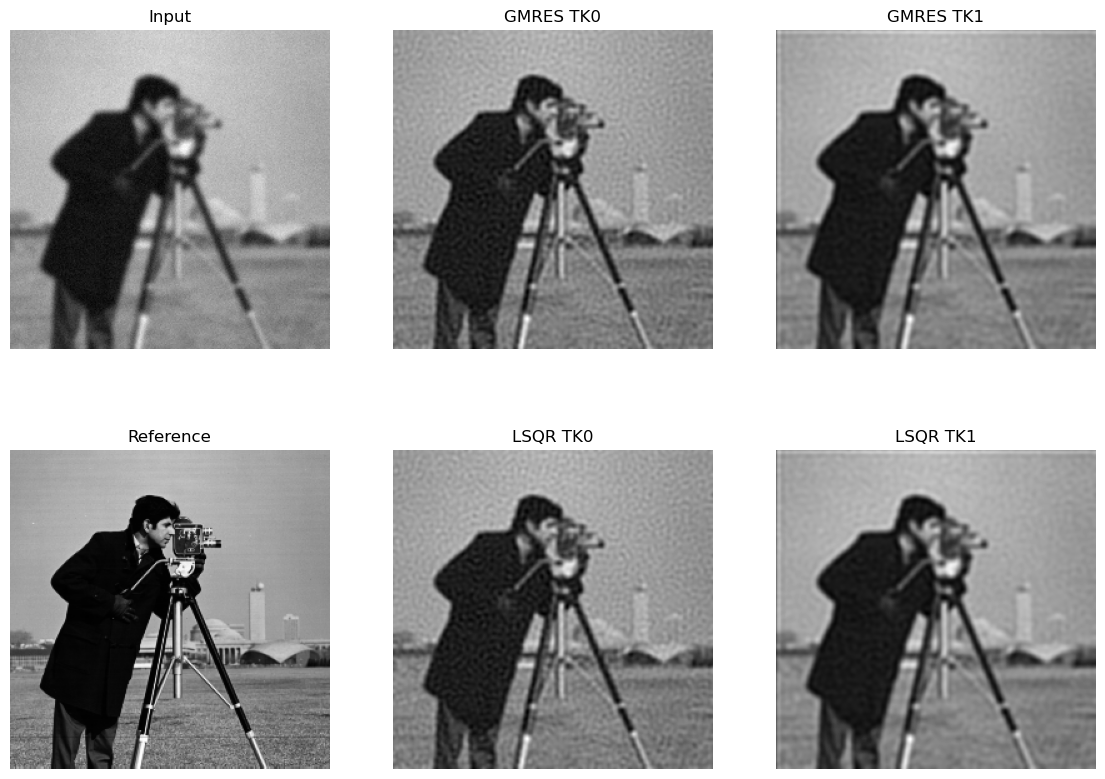

In [9]:
"""Compare different techniques"""

_, axs = plt.subplots(2, 3, figsize=(14, 10))
axs[0, 0].imshow(g, cmap="gray")
axs[0, 0].set_title("Input")
axs[0, 0].axis("off")
axs[0, 1].imshow(gmres_tk0_f_hat, cmap="gray")
axs[0, 1].set_title("GMRES TK0")
axs[0, 1].axis("off")
axs[0, 2].imshow(gmres_tk1_f_hat, cmap="gray")
axs[0, 2].set_title("GMRES TK1")
axs[0, 2].axis("off")
axs[1, 0].imshow(f, cmap="gray")
axs[1, 0].set_title("Reference")
axs[1, 0].axis("off")
axs[1, 1].imshow(lsqr_tk0_f_hat, cmap="gray")
axs[1, 1].set_title("LSQR TK0")
axs[1, 1].axis("off")
axs[1, 2].imshow(lsqr_tk1_f_hat, cmap="gray")
axs[1, 2].set_title("LSQR TK1")
axs[1, 2].axis("off")
plt.show()